## Baseline basée sur les côtes

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
df_ultimate = pd.read_csv('/Users/paulin/Desktop/Deploying_ML_project/Albert_group/df_ultimate.csv')

In [23]:
df_ultimate.columns

Index(['match_id', 'date', 'round', 'home', 'home_winner', 'formation_home',
       'coach_home', 'dob_coach_home', 'trophies_home', 'foundation_home',
       'away', 'away_winner', 'formation_away', 'coach_away', 'dob_coach_away',
       'trophies_away', 'foundation_away', 'venue_city', 'venue_capacity',
       'league', 'temperature', 'wind_speed', 'clouds', 'humidity', 'pressure',
       'draw', 'league_name', 'league_country', 'major_league',
       'eliminatory_round', 'venue_surface_artificial turf',
       'venue_surface_grass', 'home_defenders', 'home_midfielders',
       'home_forwards', 'home_goal_scorers', 'away_defenders',
       'away_midfielders', 'away_forwards', 'away_goal_scorers',
       'home_victory_serie', 'away_victory_serie',
       'home_days_since_last_match', 'away_days_since_last_match', 'year',
       'month', 'day', 'odd_home', 'odd_away', 'odd_draw'],
      dtype='object')

In [24]:
df_ultimate["results"] = df_ultimate[["home_winner", "away_winner", "draw"]].idxmax(axis=1)


              precision    recall  f1-score   support

 home_winner       0.42      0.74      0.53      3063
 away_winner       0.41      0.33      0.37      2757
        draw       0.41      0.00      0.01      1838

    accuracy                           0.42      7658
   macro avg       0.41      0.36      0.30      7658
weighted avg       0.41      0.42      0.35      7658



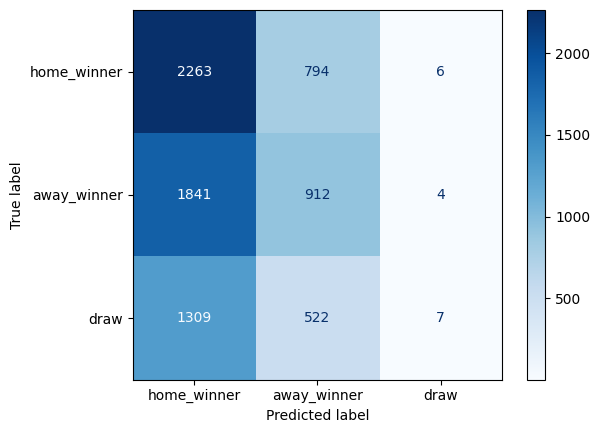

In [25]:
def predict_from_odds(row):
    odds = {
        'home_winner': row['odd_home'],
        'away_winner': row['odd_away'],
        'draw': row['odd_draw']
    }
    return min(odds, key=odds.get)

df_ultimate['predicted'] = df_ultimate.apply(predict_from_odds, axis=1)


cm = confusion_matrix(df_ultimate['results'], df_ultimate['predicted'], labels=['home_winner', 'away_winner', 'draw'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['home_winner', 'away_winner', 'draw'])


report = classification_report(df_ultimate['results'], df_ultimate['predicted'], labels=['home_winner', 'away_winner', 'draw'])
print(report)

disp.plot(cmap="Blues")

## Modèle Random Forest

In [26]:
X = df_ultimate[['dob_coach_home', 'trophies_home', 'foundation_home', 'dob_coach_away','trophies_away', 'foundation_away', 'venue_capacity', 'temperature','wind_speed', 'clouds', 'humidity', 'pressure', 'odd_home', 'odd_draw','odd_away', 'major_league', 'eliminatory_round','venue_surface_artificial turf', 'venue_surface_grass','home_defenders', 'home_midfielders', 'home_forwards','home_goal_scorers', 'away_defenders', 'away_midfielders','away_forwards', 'away_goal_scorers', 'home_victory_serie','away_victory_serie', 'home_days_since_last_match','away_days_since_last_match', 'year', 'month', 'day']]

y = df_ultimate["results"]

In [27]:
print(X.shape)
X.head()

(7658, 34)


,dob_coach_home,trophies_home,foundation_home,dob_coach_away,trophies_away,foundation_away,venue_capacity,temperature,wind_speed,clouds,...,away_midfielders,away_forwards,away_goal_scorers,home_victory_serie,away_victory_serie,home_days_since_last_match,away_days_since_last_match,year,month,day
0,1968.0,7,1907.0,1973.0,3,2015.000000,2500.0,25.06,2.24,0.02,...,1,4,1,0,0,0.0,0.0,2024,7,9
1,1982.0,3,1907.0,1982.0,9,1876.826861,3000.0,28.58,3.82,0.02,...,5,2,2,0,0,0.0,0.0,2024,7,9
2,1977.0,13,1959.0,1977.0,5,1926.000000,1500.0,20.47,3.67,0.95,...,2,3,1,0,0,0.0,0.0,2024,7,9
3,1987.0,8,1995.0,1966.0,4,1876.826861,2000.0,23.21,5.19,0.08,...,3,3,3,0,0,0.0,0.0,2024,7,9
4,1973.0,15,1908.0,1984.0,17,1901.000000,1500.0,12.93,3.83,1.00,...,5,2,2,0,0,0.0,0.0,2024,7,9


In [28]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]  
}

# Le grid search va par défaut utiliser le stratified KFold pour les problèmes de classificationn multiclasse ce qui va nous permettre de garder l'équilibre entre ces classes pendant l'entrainement
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_sample

              precision    recall  f1-score   support

 away_winner       0.47      0.54      0.51       551
        draw       0.00      0.00      0.00       368
 home_winner       0.47      0.69      0.56       613

    accuracy                           0.47      1532
   macro avg       0.32      0.41      0.36      1532
weighted avg       0.36      0.47      0.41      1532



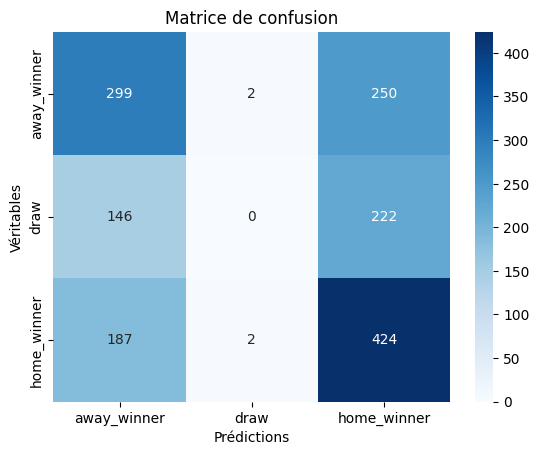

In [31]:
# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["away_winner","draw", "home_winner"], yticklabels=["away_winner","draw", "home_winner"])
plt.title("Matrice de confusion")
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()



In [32]:
import joblib

# Sauvegarder le modèle au format pkl
joblib.dump(best_rf, 'rf_model.pkl')

['rf_model.pkl']